In [101]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats

In [89]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


In [2]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/'

## patients

In [3]:
df = pd.read_excel(PATH +'GR_all6M_MPP.xlsx', index_col=0, na_values=[' ', '', -99.0])
df = df[df.index.notnull()].drop(columns=['Unnamed: 98', 'Unnamed: 99'])

In [4]:
# total ftd - saps34
# sex_nr - female = 1, male = 0
# ausja_bl = education years at baseline (i.e. 6 months before the NET interview)
# pa - panss
df.columns

Index(['Messzeitpunkt', 'age', 'sex_nr', 'Bildungsjahre', 'ausja_bl',
       'IQ_kristallin', 'saps1', 'saps2', 'saps3', 'saps4', 'saps5', 'saps6',
       'saps7', 'saps8', 'saps9', 'saps10', 'saps11', 'saps12', 'saps13',
       'saps14', 'saps15', 'saps16', 'saps17', 'saps18', 'saps19', 'saps20',
       'saps21', 'saps22', 'saps23', 'saps24', 'saps25', 'saps26', 'saps27',
       'saps28', 'saps29', 'saps30', 'saps31', 'saps32', 'saps33', 'saps34',
       'saps35', 'sans1', 'sans2', 'sans3', 'sans4', 'sans5', 'sans6', 'sans7',
       'sans8', 'sans9', 'sans10', 'sans11', 'sans12', 'sans13', 'sans14',
       'sans15', 'sans16', 'sans17', 'sans18', 'sans19', 'sans20', 'sans21',
       'sans22', 'sans23', 'sans24', 'pa_01', 'pa_02', 'pa_03', 'pa_04',
       'pa_05', 'pa_06', 'pa_07', 'pa_08', 'pa_09', 'pa_10', 'pa_11', 'pa_12',
       'pa_13', 'pa_14', 'pa_15', 'pa_16', 'pa_17', 'pa_18', 'pa_19', 'pa_20',
       'pa_21', 'pa_22', 'pa_23', 'pa_24', 'pa_25', 'pa_26', 'pa_27', 'pa_28',
     

In [5]:
print(*enumerate('PANSS P1	PANSS P2	PANSS P3	PANSS P4	PANSS P5	PANSS P6	PANSS P7	PANSS N1	PANSS N2	PANSS N3	PANSS N4	PANSS N5	PANSS N6	PANSS N7	PANSS O1	PANSS O2	PANSS O3	PANSS O4	PANSS O5	PANSS O6	PANSS O7	PANSS O8	PANSS 09	PANSS O10	PANSS O11	PANSS O12	PANSS O13	PANSS O14	PANSS O15	PANSS 016'.split('\t')))

(0, 'PANSS P1') (1, 'PANSS P2') (2, 'PANSS P3') (3, 'PANSS P4') (4, 'PANSS P5') (5, 'PANSS P6') (6, 'PANSS P7') (7, 'PANSS N1') (8, 'PANSS N2') (9, 'PANSS N3') (10, 'PANSS N4') (11, 'PANSS N5') (12, 'PANSS N6') (13, 'PANSS N7') (14, 'PANSS O1') (15, 'PANSS O2') (16, 'PANSS O3') (17, 'PANSS O4') (18, 'PANSS O5') (19, 'PANSS O6') (20, 'PANSS O7') (21, 'PANSS O8') (22, 'PANSS 09') (23, 'PANSS O10') (24, 'PANSS O11') (25, 'PANSS O12') (26, 'PANSS O13') (27, 'PANSS O14') (28, 'PANSS O15') (29, 'PANSS 016')


In [6]:
df['panss_pos'] = df[['pa_01', 'pa_02', 'pa_03', 'pa_04', 'pa_05', 'pa_06', 'pa_07']].sum(axis=1)
df['panss_neg'] = df[['pa_08', 'pa_09', 'pa_10', 'pa_11', 'pa_12', 'pa_13', 'pa_14', 'pa_15']].sum(axis=1)
df['panss_o'] = df[['pa_16', 'pa_17', 'pa_18', 'pa_19', 'pa_20', 'pa_21', 'pa_22', 'pa_23', 'pa_24', 'pa_25', 'pa_26', 'pa_27', 'pa_28', 'pa_29', 'pa_30']].sum(axis=1)
df['panss_total'] = df[['panss_pos', 'panss_neg', 'panss_o']].sum(axis=1)
df['saps_total'] = df[['saps1', 'saps2', 'saps3', 'saps4', 'saps5', 'saps6', 'saps7', 'saps8', 'saps9', 'saps10', 'saps11', 'saps12', 'saps13', 'saps14', 'saps15', 'saps16', 'saps17', 'saps18', 'saps19', 'saps20', 'saps21', 'saps22', 'saps23', 'saps24', 'saps25', 'saps26', 'saps27', 'saps28', 'saps29', 'saps30', 'saps31', 'saps32', 'saps33', 'saps34', 'saps35']].sum(axis=1)
df['sans_total'] =  df[['sans1', 'sans2', 'sans3', 'sans4', 'sans5', 'sans6', 'sans7', 'sans8', 'sans9', 'sans10', 'sans11', 'sans12', 'sans13', 'sans14', 'sans15', 'sans16', 'sans17', 'sans18', 'sans19', 'sans20', 'sans21', 'sans22', 'sans23', 'sans24']].sum(axis=1)

#### filter out only the ones I have transcripts for

In [7]:
df.index

Index(['MPP_001', 'MPP_002', 'MPP_003', 'MPP_004', 'MPP_005', 'MPP_006',
       'MPP_007', 'MPP_008', 'MPP_009', 'MPP_010',
       ...
       'MPP_122', 'MPP_123', 'MPP_124', 'MPP_125', 'MPP_126', 'MPP_127',
       'MPP_128', 'MPP_129', 'MPP_130', 'MPP_131'],
      dtype='object', name='Pat.ID', length=130)

In [8]:
df.index.rename('ID', inplace=True)

In [9]:
res = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_new_try.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [10]:
idxs = sorted([x.replace('_6M_manual_c', '') for x in res.index])
idxs = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in idxs]

In [11]:
res.index = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in [x.replace('_6M_manual_c', '') for x in res.index]]
res.index.rename('ID', inplace=True)

In [12]:
set(idxs).difference(set(df.index))

set()

In [13]:
df = df.loc[idxs]

#### descriptitve stats

In [14]:
cols = ['age', 'sex_nr', 'Bildungsjahre', 'IQ_kristallin', 'saps34', 'saps_total', 'sans_total', 'sans12', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [15]:
df[cols].describe(percentiles=[])

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
count,59.000000,59.00000,59.000000,58.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,39.491525,0.40678,14.618644,105.155172,1.033898,16.813559,27.728814,0.915254,12.661017,16.847458,27.750847,57.259322
std,11.105098,0.49545,2.954160,15.652814,1.049895,16.697589,20.353624,1.193201,5.475998,6.025273,7.514018,16.183219
min,21.000000,0.00000,10.000000,35.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,15.000000,31.000000
50%,38.000000,0.00000,14.000000,107.000000,1.000000,10.000000,24.000000,0.000000,11.000000,16.000000,27.000000,53.000000
max,63.000000,1.00000,22.000000,129.000000,3.000000,61.000000,79.000000,4.000000,29.000000,33.000000,48.400000,110.400000


In [16]:
df[cols].groupby('sex_nr').describe(percentiles=[])

age                                         Bildungsjahre             \
       count       mean        std   min   50%   max         count       mean   
sex_nr                                                                          
0.0     35.0  37.285714  10.115717  22.0  37.0  62.0          35.0  14.542857   
1.0     24.0  42.708333  11.896215  21.0  40.0  63.0          24.0  14.729167   

                        ...   panss_o                   panss_total  \
             std   min  ...       std   min   50%   max       count   
sex_nr                  ...                                           
0.0     3.106851  11.0  ...  7.634719  18.0  27.0  48.4        35.0   
1.0     2.777938  10.0  ...  7.297586  15.0  27.0  40.0        24.0   

                                                  
             mean        std   min    50%    max  
sex_nr                                            
0.0     59.154286  16.994053  36.0  54.00  110.4  
1.0     54.495833  14.835195  31.0  51.25   83.0  

[2 rows x 66 columns]

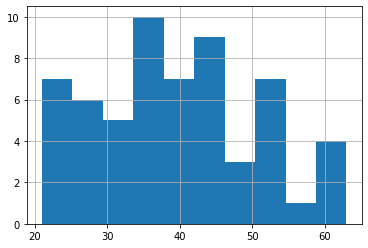

In [17]:
df.age.hist();

## Healthy controls

In [18]:
df_hc = pd.read_csv(PATH + 'HC/NET_HC.csv', index_col=0, na_values=[' ', ''])

In [19]:
df_hc.columns

Index(['age', 'sex_nr', 'Bildungsjahre'], dtype='object')

In [20]:
df_hc.describe()

,age,sex_nr,Bildungsjahre
count,20.00000,20.000000,19.000000
mean,43.85000,0.450000,15.500000
std,13.29137,0.510418,2.783882
min,19.00000,0.000000,11.000000
25%,33.00000,0.000000,13.000000
50%,44.50000,0.000000,16.000000
75%,52.00000,1.000000,18.000000
max,68.00000,1.000000,20.000000


In [21]:
df_hc.groupby('sex_nr').describe(percentiles=[])

age                                         Bildungsjahre             \
       count       mean        std   min   50%   max         count       mean   
sex_nr                                                                          
0.0     11.0  42.272727  12.240024  25.0  43.0  65.0          10.0  15.700000   
1.0      9.0  45.777778  14.989811  19.0  50.0  68.0           9.0  15.277778   

                                    
             std   min   50%   max  
sex_nr                              
0.0     3.128720  12.0  17.0  20.0  
1.0     2.513851  11.0  16.0  19.0

In [22]:
df_hc.index

Index(['KG_001', 'KG_002', 'KG_003', 'KG_004', 'KG_005', 'KG_006', 'KG_007',
       'KG_008', 'KG_009', 'KG_010', 'KG_011', 'KG_012', 'KG_013', 'KG_014',
       'KG_015', 'KG_016', 'KG_017', 'KG_018', 'KG_019', 'KG_020',      nan],
      dtype='object', name='Pat.ID')

In [23]:
res_hc =  pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_HC.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [24]:
idxs_HC = sorted([x.replace('_c', '').replace('NET_', '')  for x in res_hc.index])

In [25]:
set(idxs_HC).difference(set(df_hc.index))

set()

In [26]:
df_hc = df_hc.loc[idxs_HC]

In [27]:
df_hc.index.rename('ID', inplace=True)

In [28]:
res_hc.index = [x.replace('_c', '').replace('NET_', '')  for x in res_hc.index]
res_hc.index.rename('ID', inplace=True)

In [29]:
merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')
corr_hc = merged_hc.corr()

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_16809/1853110338.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')


### age

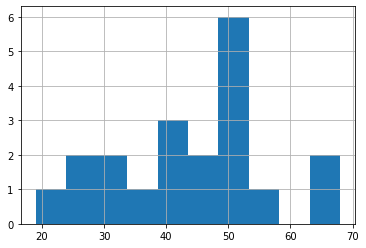

In [30]:
df_hc.age.hist();

In [31]:
df_hc[df_hc.age > 60]

,age,sex_nr,Bildungsjahre
ID,,,
KG_010,65.0,0.0,18.0
KG_015,68.0,1.0,16.0


In [32]:
corr_hc[abs(corr_hc['age']) > 0.3].index

Index(['age', ('LM', 'm_gcoh'), ('syntactic', 'INTJ')], dtype='object')

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


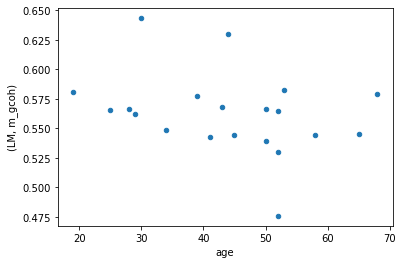

In [33]:
merged_hc.plot.scatter('age', ('LM', 'm_gcoh'));

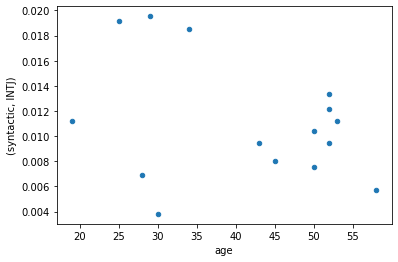

In [34]:
merged_hc.plot.scatter('age', ('syntactic', 'INTJ'));

In [35]:
corr_hc[abs(corr_hc['age']) > 0.5].index

Index(['age'], dtype='object')

### education years

In [36]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.3].index

Index([               'Bildungsjahre',              ('LM', 'm_cgcoh'),
                     ('LM', 'm_gcoh'),               ('LM', 'm_lcoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L1'),        ('graph', 'degree_std'),
                 ('syntactic', 'ADP'),         ('syntactic', 'CCONJ'),
                 ('syntactic', 'NUM'),         ('syntactic', 'PUNCT'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'min_sent_len'),  ('syntactic', 'std_sent_len')],
      dtype='object')

In [37]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.5].index

Index(['Bildungsjahre', ('syntactic', 'std_sent_len')], dtype='object')

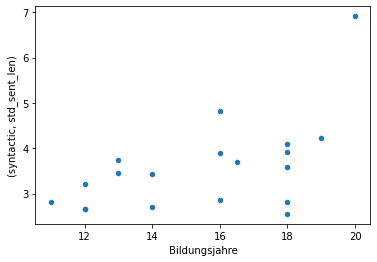

In [38]:
merged_hc.plot.scatter('Bildungsjahre', ('syntactic', 'std_sent_len'));

### sentence length

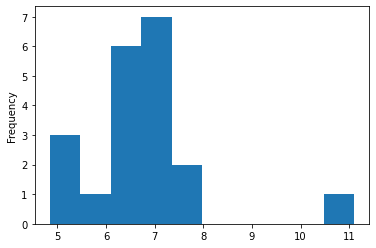

In [39]:
merged_hc[('syntactic', 'mean_sent_len')].plot.hist();

In [40]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.3].index

Index([               'Bildungsjahre',              ('LM', 'm_cgcoh'),
                     ('LM', 'm_gcoh'),               ('LM', 'm_lcoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L2'),                ('graph', 'L3'),
                     ('graph', 'LCC'),               ('graph', 'LSC'),
                      ('graph', 'PE'),    ('graph', 'degree_average'),
              ('graph', 'degree_std'),   ('graph', 'number_of_edges'),
         ('graph', 'number_of_nodes'),           ('lexical', 'MALTR'),
               ('lexical', 'n_words'),           ('syntactic', 'ADJ'),
                 ('syntactic', 'ADV'),         ('syntactic', 'CCONJ'),
                 ('syntactic', 'DET'),          ('syntactic', 'INTJ'),
                ('syntactic', 'NOUN'),          ('syntactic', 'PART'),
                ('syntactic', 'PRON'),         ('syntactic', 'PROPN'),
               ('syntactic', 'PUNCT'),         ('syntactic', 'SCONJ'),
      

In [41]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.5].index

Index([             ('LM', 'm_cgcoh'),               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),               ('LM', 'm_scoh'),
                    ('LM', 'm_sporb'),                ('graph', 'L2'),
                     ('graph', 'LCC'),               ('graph', 'LSC'),
          ('graph', 'degree_average'),        ('graph', 'degree_std'),
         ('graph', 'number_of_nodes'),           ('lexical', 'MALTR'),
                 ('syntactic', 'ADV'),          ('syntactic', 'PART'),
               ('syntactic', 'PUNCT'),         ('syntactic', 'SCONJ'),
                ('syntactic', 'VERB'),  ('syntactic', 'max_sent_len'),
       ('syntactic', 'mean_sent_len'),  ('syntactic', 'std_sent_len')],
      dtype='object')

In [42]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index

Index([              ('LM', 'm_lcoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L2'),               ('graph', 'LCC'),
                     ('graph', 'LSC'),    ('graph', 'degree_average'),
              ('graph', 'degree_std'),   ('graph', 'number_of_nodes'),
                 ('lexical', 'MALTR'),         ('syntactic', 'PUNCT'),
               ('syntactic', 'SCONJ'),          ('syntactic', 'VERB'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [43]:
corr_hc.loc[corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index][('syntactic', 'mean_sent_len')].sort_values(ascending=True)

(syntactic, PUNCT)           -0.917304
(graph, degree_std)          -0.753192
(syntactic, SCONJ)           -0.692073
(graph, degree_average)      -0.647738
(graph, L2)                  -0.626925
(LM, m_sporb)                 0.609928
(syntactic, VERB)             0.633447
(LM, m_lcoh)                  0.656025
(graph, LSC)                  0.673320
(graph, LCC)                  0.681868
(graph, number_of_nodes)      0.681868
(lexical, MALTR)              0.779730
(syntactic, max_sent_len)     0.801093
(syntactic, std_sent_len)     0.908100
(syntactic, mean_sent_len)    1.000000
Name: (syntactic, mean_sent_len), dtype: float64

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


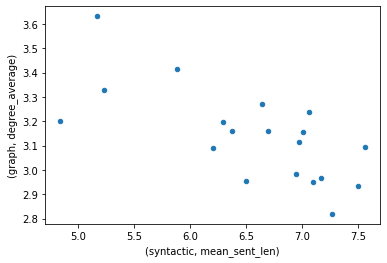

In [44]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 11].plot.scatter(('syntactic', 'mean_sent_len'), ('graph', 'degree_average'));

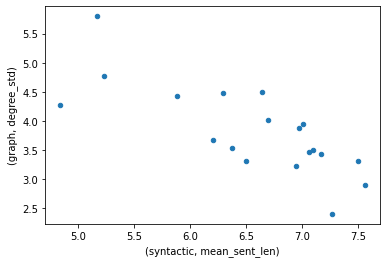

In [45]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 11].plot.scatter(('syntactic', 'mean_sent_len'), ('graph', 'degree_std'));

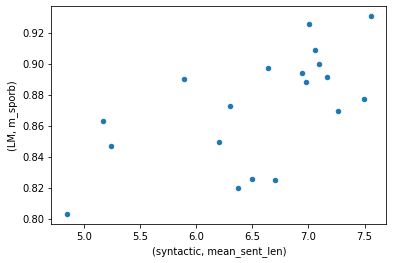

In [46]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 11].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_sporb'));

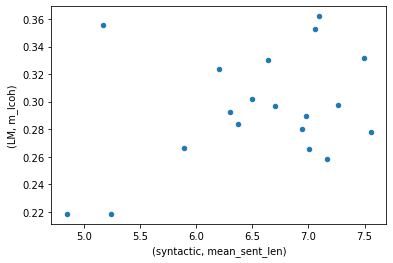

In [47]:
merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 11].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_lcoh'));

## Merge socio/psychiatric data

In [48]:
df['group'] = 1
df_hc['group'] = 0
compare_groups = pd.concat([df[cols + ['group']], df_hc], axis=0)

In [49]:
compare_groups.groupby(['group']).describe(percentiles=[])

age                                         sex_nr                     \
      count       mean        std   min   50%   max  count     mean       std   
group                                                                           
0      20.0  43.850000  13.291370  19.0  44.5  68.0   20.0  0.45000  0.510418   
1      59.0  39.491525  11.105098  21.0  38.0  63.0   59.0  0.40678  0.495450   

            ...   panss_o                   panss_total                        \
       min  ...       std   min   50%   max       count       mean        std   
group       ...                                                                 
0      0.0  ...       NaN   NaN   NaN   NaN         0.0        NaN        NaN   
1      0.0  ...  7.514018  15.0  27.0  48.4        59.0  57.259322  16.183219   

                          
        min   50%    max  
group                     
0       NaN   NaN    NaN  
1      31.0  53.0  110.4  

[2 rows x 72 columns]

In [50]:
compare_groups.groupby(['group', 'sex_nr']).describe(percentiles=[])

age                                         Bildungsjahre  \
             count       mean        std   min   50%   max         count   
group sex_nr                                                               
0     0.0     11.0  42.272727  12.240024  25.0  43.0  65.0          10.0   
      1.0      9.0  45.777778  14.989811  19.0  50.0  68.0           9.0   
1     0.0     35.0  37.285714  10.115717  22.0  37.0  62.0          35.0   
      1.0     24.0  42.708333  11.896215  21.0  40.0  63.0          24.0   

                                         ...   panss_o                    \
                   mean       std   min  ...       std   min   50%   max   
group sex_nr                             ...                               
0     0.0     15.700000  3.128720  12.0  ...       NaN   NaN   NaN   NaN   
      1.0     15.277778  2.513851  11.0  ...       NaN   NaN   NaN   NaN   
1     0.0     14.542857  3.106851  11.0  ...  7.634719  18.0  27.0  48.4   
      1.0     14.729167  2.777938  10.0  ...  7.297586  15.0  27.0  40.0   

             panss_total                                            
                   count       mean        std   min    50%    max  
group sex_nr                                                        
0     0.0            0.0        NaN        NaN   NaN    NaN    NaN  
      1.0            0.0        NaN        NaN   NaN    NaN    NaN  
1     0.0           35.0  59.154286  16.994053  36.0  54.00  110.4  
      1.0           24.0  54.495833  14.835195  31.0  51.25   83.0  

[4 rows x 66 columns]

In [51]:
stats.ttest_ind(df['age'], df_hc['age']).pvalue

0.15339927043476997

In [52]:
stats.ttest_ind(df['Bildungsjahre'], df_hc['Bildungsjahre'], nan_policy='omit').pvalue

0.2552563345667248

In [53]:
combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_16809/1114475667.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')


In [54]:
combined_data_averaged.columns

Index([                         'age',                       'sex_nr',
                      'Bildungsjahre',                'IQ_kristallin',
                             'saps34',                   'saps_total',
                         'sans_total',                       'sans12',
                          'panss_pos',                    'panss_neg',
                            'panss_o',                  'panss_total',
                              'group',               ('LM', 'm_lcoh'),
                     ('LM', 'm_gcoh'),              ('LM', 'm_cgcoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                ('LM', 'm_bert_lcoh'),          ('LM', 'm_bert_gcoh'),
               ('LM', 'm_bert_cgcoh'),          ('LM', 'm_bert_scoh'),
             ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len'),  ('syntactic', 'min_sent_len'),
        ('syntactic', 'max_sent_len'),         ('syntactic', 'SPACE'),
      

In [164]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x', alpha=0.05):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res_df = pd.DataFrame(columns=[stat_name, 'p', 'sig', f'abs_{stat_name}'], index=columns_to_test)

    for column in columns_to_test:
        if nan_policy:
            section = df[[target_column, column]].dropna()
        else:
            raise ValueError('correlation does not allow nan propagation')
            
        if section.empty:
            r, p = np.nan, np.nan
        else:
            r, p = list(test(section[target_column], section[column]))  
        res_df.loc[[column]] = [r, p, p<alpha, abs(r)]
        
    return res_df.sort_values([f'abs_{stat_name}', 'p'], ascending=False).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds'), res_df

In [59]:
def display_group_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x', alpha=0.05):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res_df = pd.DataFrame(columns=[stat_name, 'p', 'sig', f'abs_{stat_name}'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[df[target_column]==1][column], df[df[target_column]==0][column], nan_policy=nan_policy))
        res_df.loc[[column]] = [r, p, p<alpha, abs(r)]
        
#     reject, pvalscorr = multipletests(res['p'], alpha=alpha, method='b')[:2]
#     res['bonf'], res['bonf_sig'] = pvalscorr, reject
#     'bonf', 'bonf_sig'
#     res_df = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig'], index=columns_to_test)
    return res_df.sort_values([f'abs_{stat_name}', 'p'], ascending=False).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [56]:
cols_av = [('LM', 'm_lcoh'), ('LM', 'm_gcoh'), ('LM', 'm_cgcoh'), ('LM', 'm_scoh'), ('LM', 'm_sporb'), ('LM', 'm_bert_lcoh'), ('LM', 'm_bert_gcoh'), ('LM', 'm_bert_cgcoh'), ('LM', 'm_bert_scoh'),
           ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len'), ('syntactic', 'std_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'max_sent_len'), ('syntactic', 'SPACE'), ('syntactic', 'NOUN'), ('syntactic', 'X'), ('syntactic', 'PUNCT'), ('syntactic', 'VERB'), ('syntactic', 'ADV'), ('syntactic', 'ADP'), ('syntactic', 'ADJ'), ('syntactic', 'CCONJ'), ('syntactic', 'PRON'),
           ('syntactic', 'DET'), ('syntactic', 'AUX'), ('syntactic', 'PROPN'), ('syntactic', 'PART'), ('syntactic', 'SCONJ'), ('syntactic', 'INTJ'), ('syntactic', 'NUM'),
           ('lexical', 'n_words'), ('lexical', 'LTR'), ('lexical', 'MALTR'),
           ('graph', 'number_of_nodes'), ('graph', 'number_of_edges'), ('graph', 'PE'), ('graph', 'LCC'), ('graph', 'LSC'), ('graph', 'degree_average'), ('graph', 'degree_std'), ('graph', 'L1'), ('graph', 'L2'), ('graph', 'L3')
          ]

In [57]:
normalized_combined_data_averaged = combined_data_averaged.copy()
normalized_combined_data_averaged[cols_av] = (combined_data_averaged[cols_av]-combined_data_averaged[cols_av].min())/(combined_data_averaged[cols_av].max()-combined_data_averaged[cols_av].min())

In [166]:
display_group_test(combined_data_averaged, cols_av, 'group', stats.ttest_ind, stat_name='t', alpha=0.0001)


,t,p,sig,abs_t
"('syntactic', 'mean_sent_len')",-6.965334,0.000000,True,6.965334
"('syntactic', 'max_sent_len')",-6.569433,0.000000,True,6.569433
"('syntactic', 'CCONJ')",6.036986,0.000000,True,6.036986
"('syntactic', 'std_sent_len')",-5.929834,0.000000,True,5.929834
"('graph', 'number_of_nodes')",-4.665794,0.000013,True,4.665794
"('graph', 'LCC')",-4.665794,0.000013,True,4.665794
"('syntactic', 'SPACE')",4.639110,0.000014,True,4.639110
"('graph', 'LSC')",-4.555959,0.000019,True,4.555959
"('LM', 'm_lcoh')",3.952036,0.000171,False,3.952036
"('LM', 'm_gcoh')",3.909927,0.000197,False,3.909927


In [223]:
a = 0.001
scales = ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]
s_saps, r_saps = display_test(combined_data_averaged, cols_av, 'saps34', stats.pearsonr, stat_name='r', alpha=a)
s_sans, r_sans = display_test(combined_data_averaged, cols_av, 'sans12', stats.pearsonr, stat_name='r', alpha=a)
s_panss, r_panss = display_test(combined_data_averaged, cols_av, 'panss_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss_pos, r_panss_pos = display_test(combined_data_averaged, cols_av, 'panss_pos', stats.pearsonr, stat_name='r', alpha=a)
s_panss_neg, r_panss_neg = display_test(combined_data_averaged, cols_av, 'panss_neg', stats.pearsonr, stat_name='r', alpha=a)
s_panss_o, r_panss_o = display_test(combined_data_averaged, cols_av, 'panss_o', stats.pearsonr, stat_name='r', alpha=a)
combined_corr = pd.concat([r_saps, r_sans, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
                     keys=scales, 
                     names=["scale"], axis=1)

In [213]:
# combined_corr.drop(columns=[(scale, "sig") for scale in scales], inplace=True)


In [224]:
combined_corr[('mean', 'abs_r')] = combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [228]:
combined_corr.sort_values(('mean', 'abs_r'), ascending=False).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [229]:
combined_corr.sort_values([('mean', 'abs_r')], ascending=False)

scale                           mean    saps34                             \
                               abs_r         r         p    sig     abs_r   
(syntactic, PART)           0.339995  0.177076   0.20464  False  0.177076   
(syntactic, SPACE)          0.331184 -0.107903  0.415953  False  0.107903   
(syntactic, DET)            0.304949  0.105899  0.459538  False  0.105899   
(graph, LSC)                0.297594  0.026415   0.84258  False  0.026415   
(graph, LCC)                0.294734  0.026421  0.842547  False  0.026421   
(graph, number_of_nodes)    0.294734  0.026421  0.842547  False  0.026421   
(syntactic, CCONJ)          0.283040 -0.269823  0.040527  False  0.269823   
(graph, number_of_edges)    0.273350  0.101337  0.445047  False  0.101337   
(syntactic, VERB)           0.262731 -0.351525  0.006332  False  0.351525   
(lexical, MALTR)            0.255997 -0.243157  0.063493  False  0.243157   
(syntactic, PUNCT)          0.246686  0.178944  0.175081  False  0.178944   
(syntactic, PRON)           0.245867  0.116546  0.379374  False  0.116546   
(syntactic, SCONJ)          0.237557  0.095677  0.483024  False  0.095677   
(syntactic, NOUN)           0.237267 -0.173239   0.18947  False  0.173239   
(lexical, n_words)          0.204877  0.183081  0.165154  False  0.183081   
(syntactic, ADP)            0.201856    0.0298  0.837235  False    0.0298   
(syntactic, INTJ)           0.200335 -0.128576  0.405529  False  0.128576   
(syntactic, max_sent_len)   0.193197  0.095951  0.469731  False  0.095951   
(syntactic, n_sents)        0.186127  0.243639  0.062954  False  0.243639   
(syntactic, mean_sent_len)  0.185015 -0.129298  0.329058  False  0.129298   
(graph, L3)                 0.181314  0.337294  0.008991  False  0.337294   
(LM, m_scoh)                0.179211 -0.016813  0.899425  False  0.016813   
(LM, m_sporb)               0.177959 -0.159318  0.228095  False  0.159318   
(syntactic, AUX)            0.175660  -0.09619  0.480673  False   0.09619   
(syntactic, NUM)            0.173844 -0.006077  0.976002  False  0.006077   
(LM, m_lcoh)                0.172793 -0.120603  0.362888  False  0.120603   
(LM, m_bert_cgcoh)          0.167428  -0.00656  0.960669  False   0.00656   
(graph, L2)                 0.160955  0.210607  0.109354  False  0.210607   
(syntactic, ADJ)            0.156695 -0.040494  0.764884  False  0.040494   
(LM, m_cgcoh)               0.153025 -0.231522   0.07767  False  0.231522   
(graph, PE)                 0.143620  0.239091   0.06819  False  0.239091   
(graph, degree_std)         0.135668  0.267817  0.040291  False  0.267817   
(syntactic, std_sent_len)   0.133986 -0.052049  0.695425  False  0.052049   
(lexical, LTR)              0.124148 -0.287892  0.027031  False  0.287892   
(syntactic, X)              0.103900 -0.003357  0.982336  False  0.003357   
(graph, degree_average)     0.099355   0.28959  0.026101  False   0.28959   
(LM, m_bert_lcoh)           0.097149  0.076305  0.565691  False  0.076305   
(LM, m_bert_scoh)           0.096643  0.036608  0.783112  False  0.036608   
(syntactic, min_sent_len)   0.094957  0.037425   0.77839  False  0.037425   
(LM, m_bert_gcoh)           0.087198  0.104672  0.430131  False  0.104672   
(syntactic, ADV)            0.085377  0.136745  0.301725  False  0.136745   
(graph, L1)                 0.085052  0.105573  0.426148  False  0.105573   
(LM, m_gcoh)                0.061517 -0.140937  0.287001  False  0.140937   
(syntactic, PROPN)          0.060790  0.086126  0.535759  False  0.086126   

scale                         sans12                                panss  \
                                   r         p    sig     abs_r         r   
(syntactic, PART)           0.380851  0.004902  False  0.380851  0.418615   
(syntactic, SPACE)          0.330594  0.010547  False  0.330594  0.448341   
(syntactic, DET)            0.309745  0.026974  False  0.309745  0.398776   
(graph, LSC)               -0.361134  0.004953  False  0.361134 -0.40825

In [95]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [111]:
def show_corrtest(df, threshold=0.05):
    p_values = calculate_pvalues(df)
    mask = p_values > threshold
    plt.figure(figsize=(40,20))
    corr = df.corr()
    sns.heatmap(corr, annot=True, mask = mask)
    plt.yticks(rotation = 0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!;
    return p_values, corr

In [155]:
def show_corrtest_mask_corr(df, threshold=0.5):
    plt.figure(figsize=(40,20))
    corr = df.corr()
    mask = corr.abs() < threshold
    sns.heatmap(corr, annot=True, mask = mask, cmap='RdBu_r')
    plt.yticks(rotation = 0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!;
    return corr

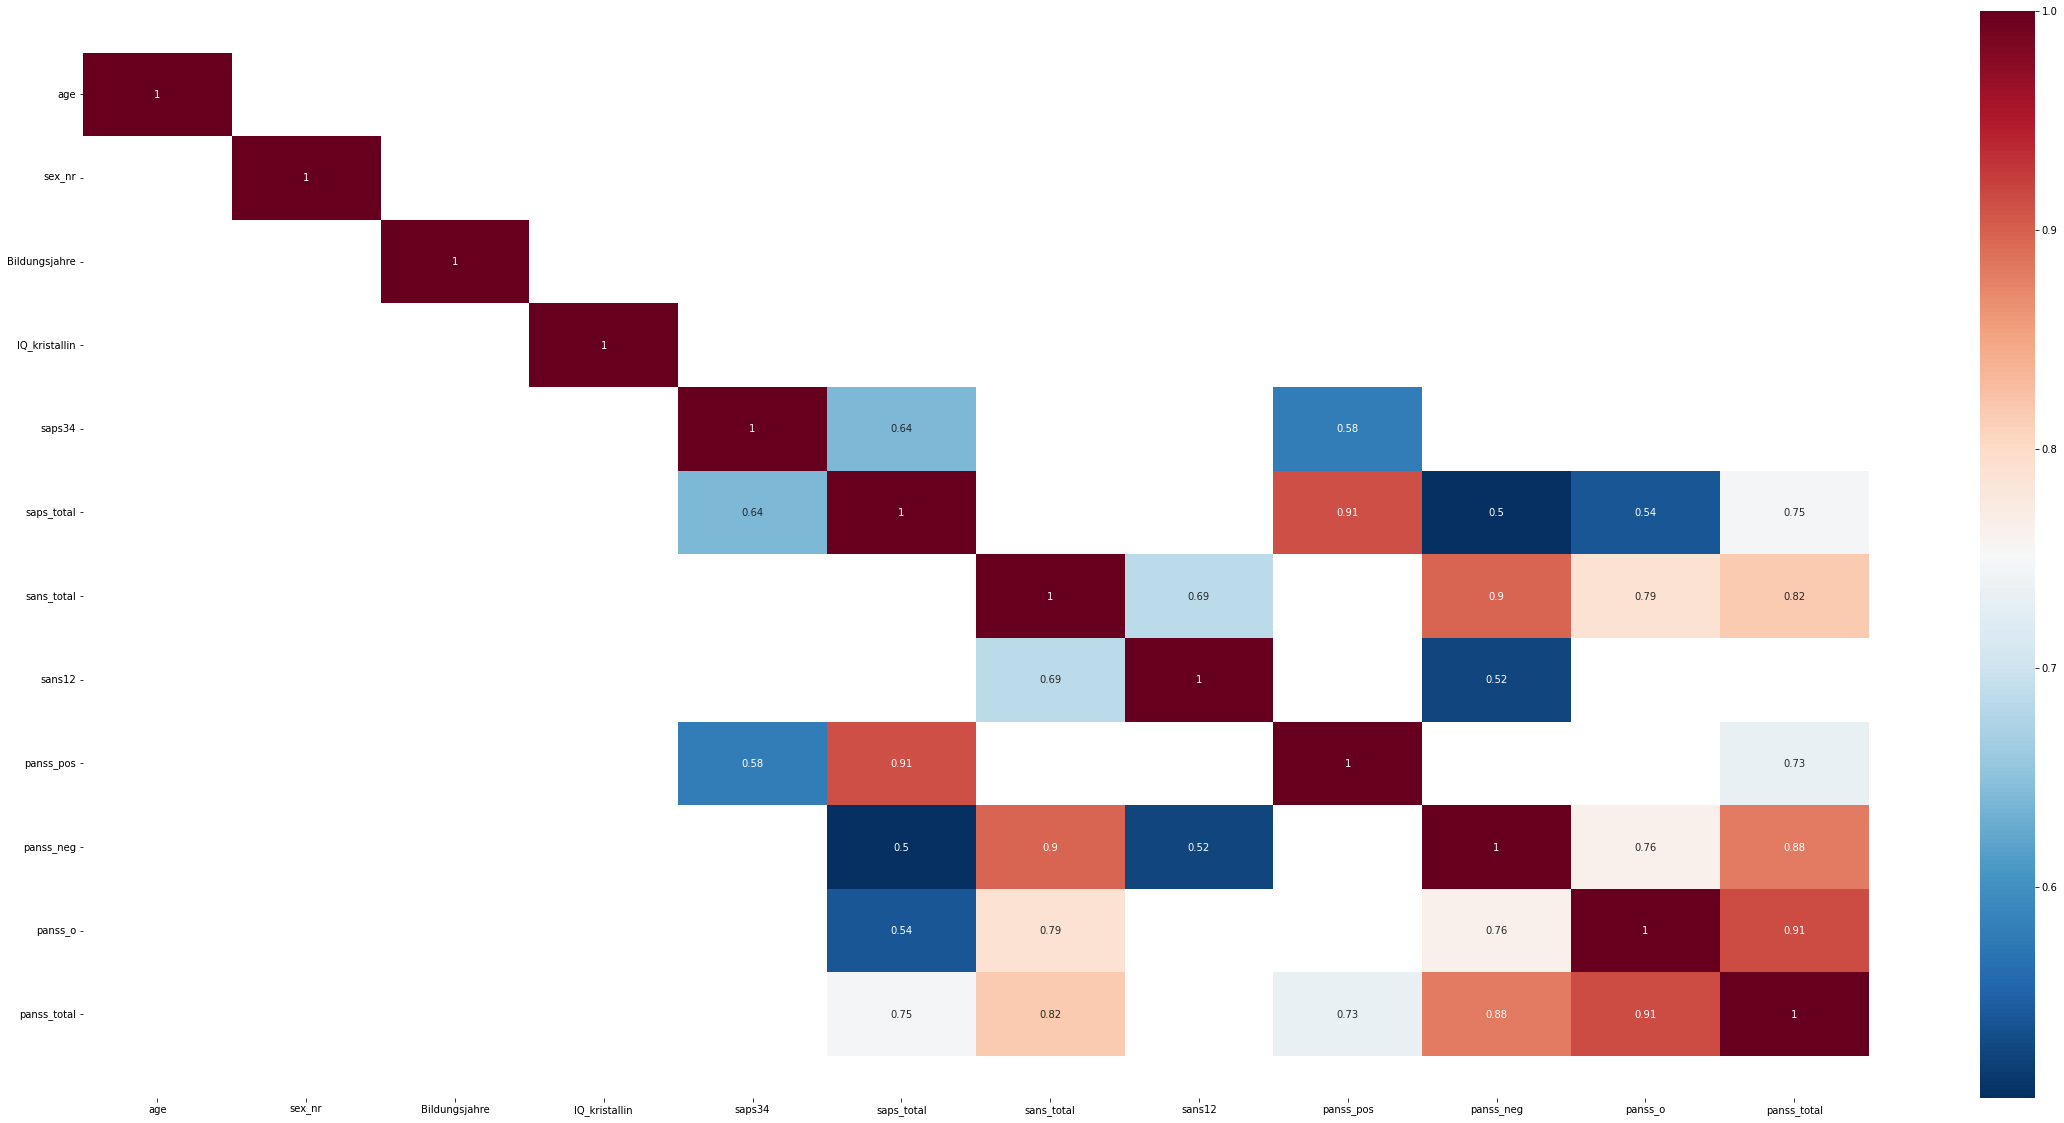

In [156]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols])
# 1. age does not correlate with IQ, education years, or psychiatric scales
# 2. IQ does not correlate with education years or psychiatric scales
# 3. saps-total correlates with saps34 and panss_pos
# 4. sans-total correlates with sans12 and panss_neg, panss_o, panss_total
# 5. panss-total correlates with panss_o, panss_neg, sans-total, panss_pos, saps-total

In [141]:
cols_LM = [col for col in cols_av if col[0] == 'LM']
cols_synt = [col for col in cols_av if col[0] == 'syntactic']
cols_lex = [col for col in cols_av if col[0] == 'lexical']
cols_graph = [col for col in cols_av if col[0] == 'graph']

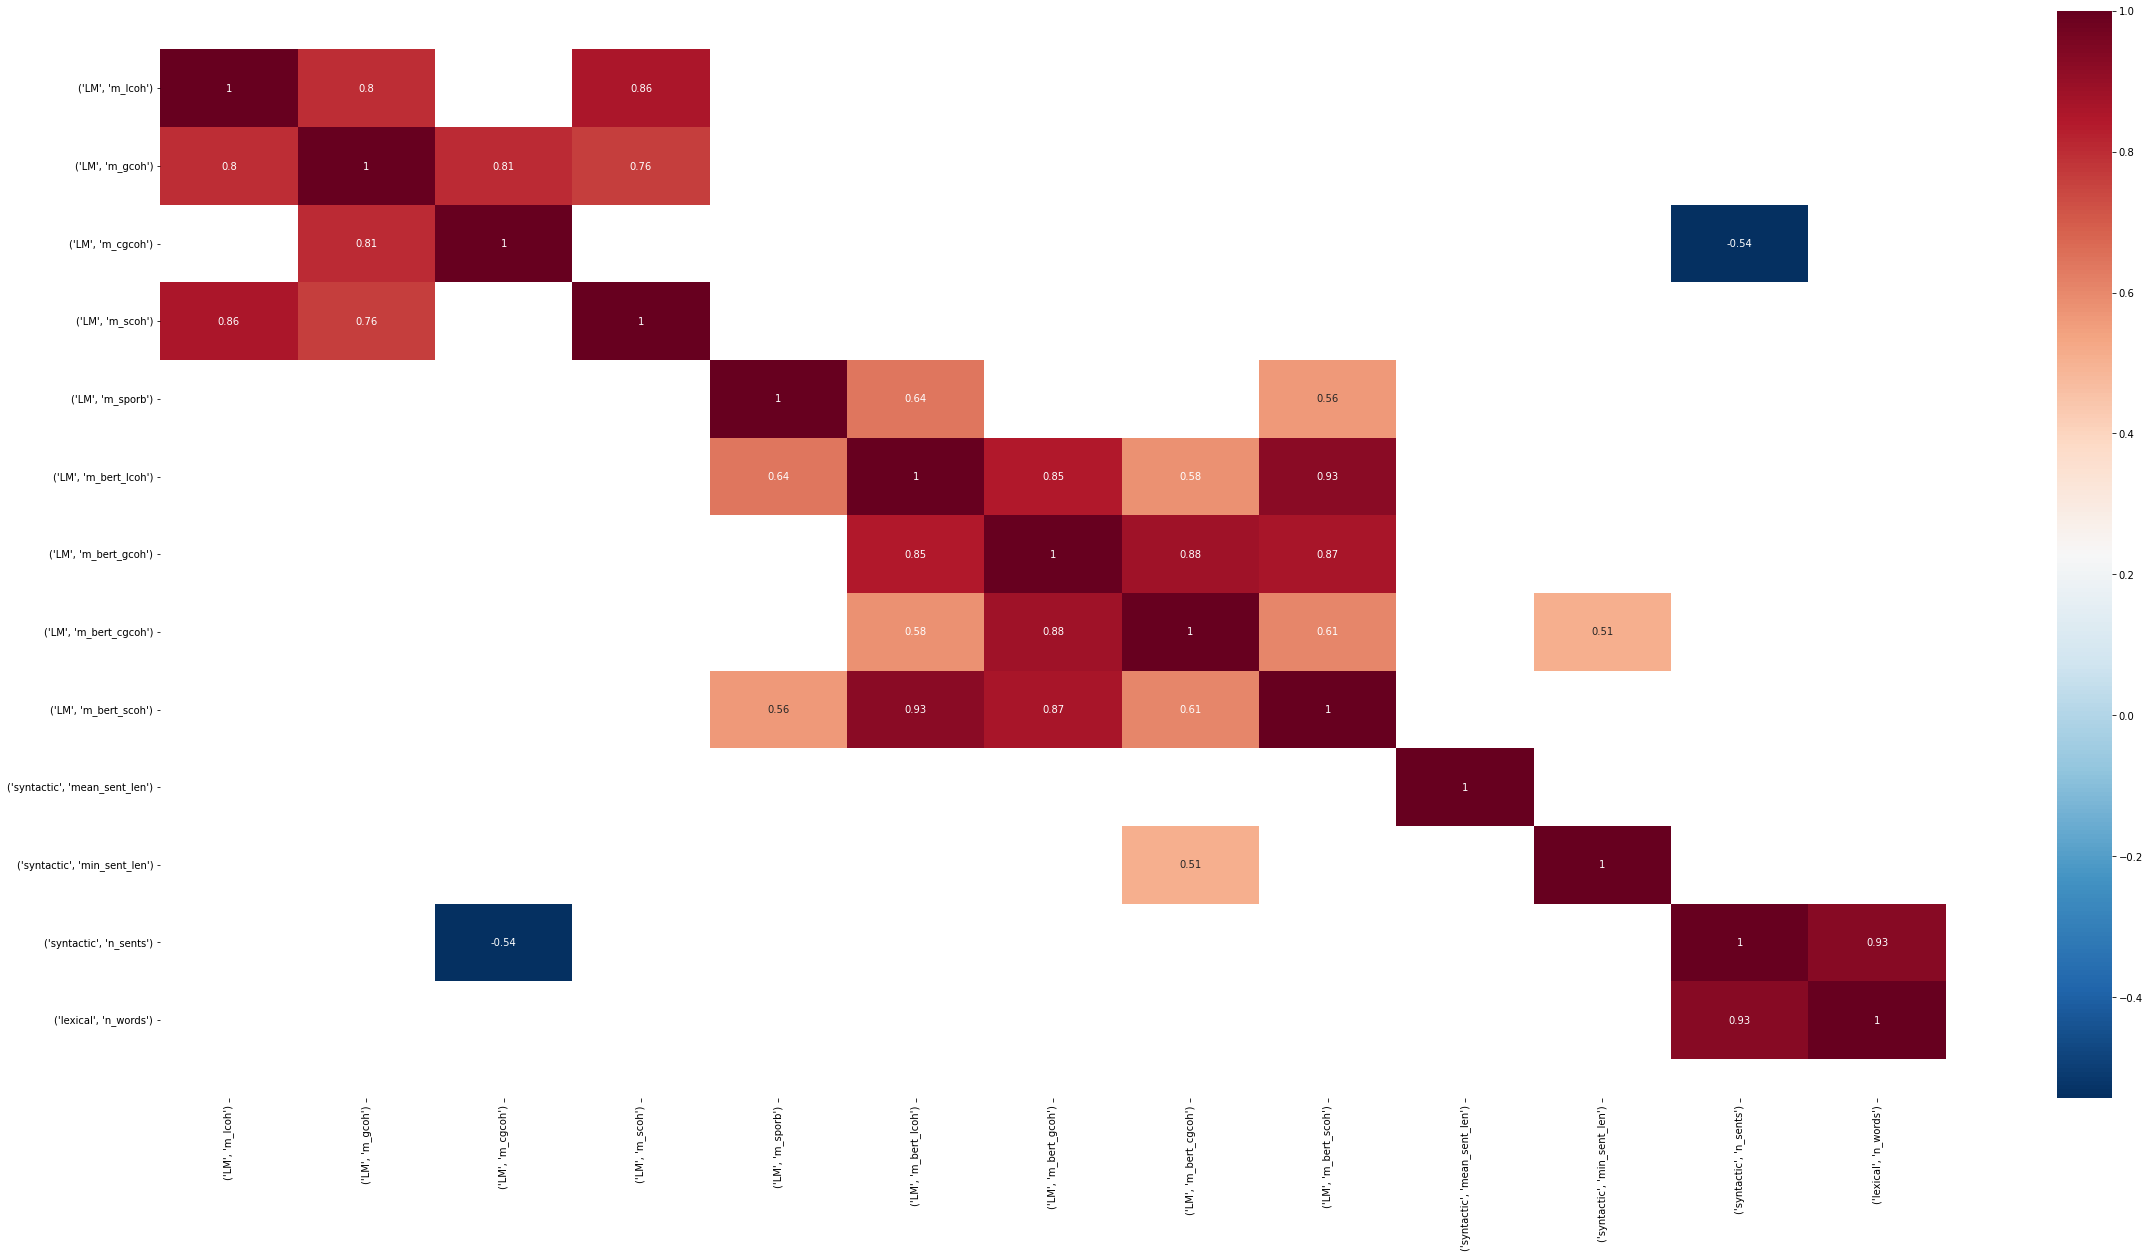

In [230]:
corr = show_corrtest_mask_corr(combined_data_averaged[LM + [('syntactic', 'mean_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]])
# 1. m_lcoh, m_gcoh, m_cgcoh, m_scoh
# 2. m_sprob, m_bert_lcoh, m_bert_gcoh, m_bert_cgcoh, m_bert_scoh
# 3. no corr with mean_sent_len or n_words, m_bert_cgcoh + min_sent_len
# 4. no corr with n_sents, m_cgcoh - n_sents

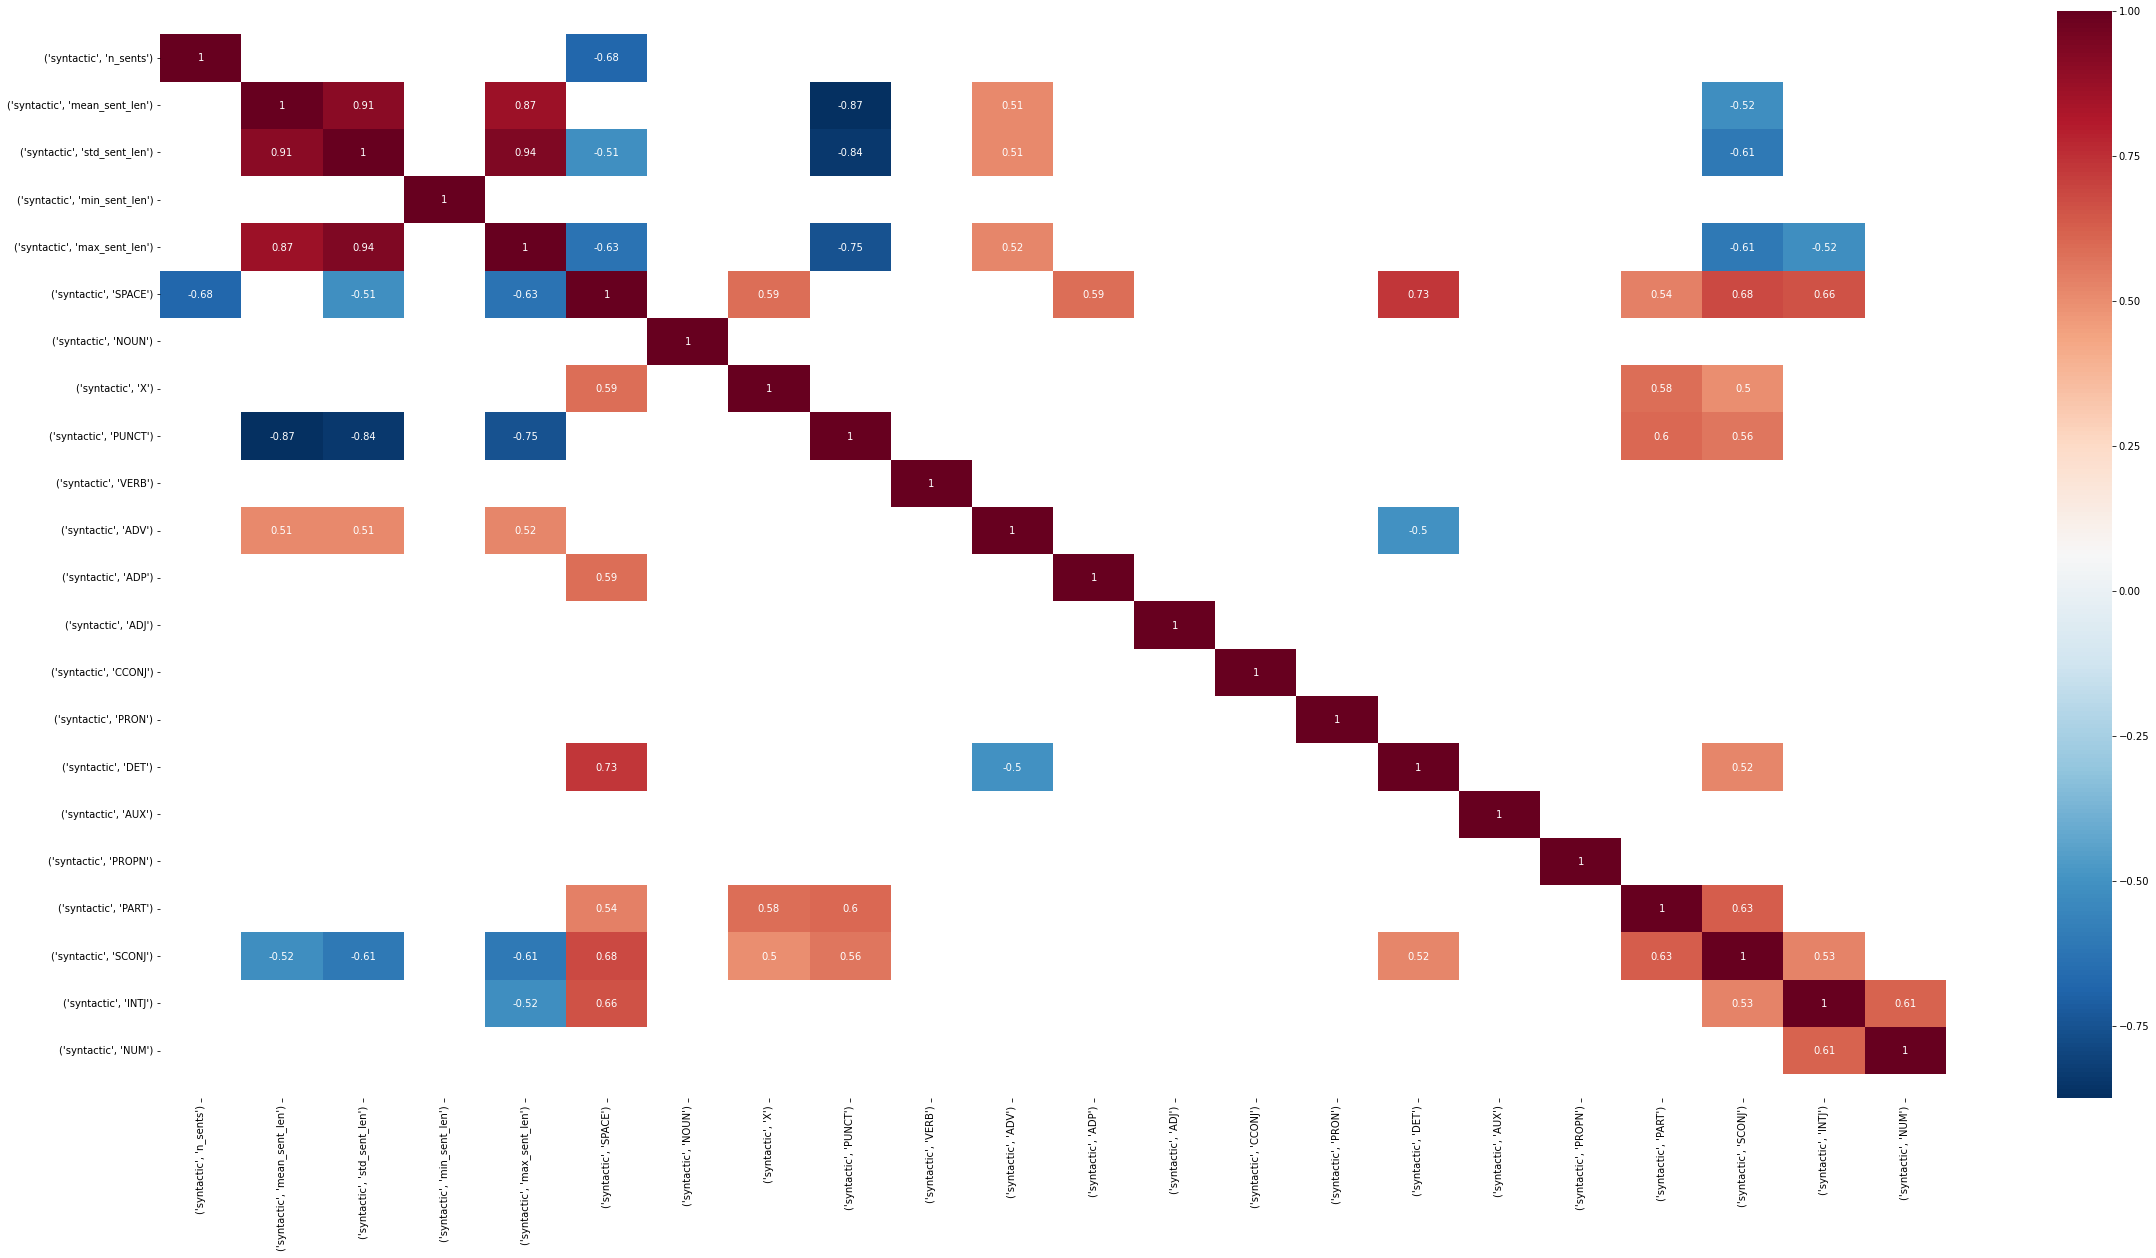

In [162]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_synt])

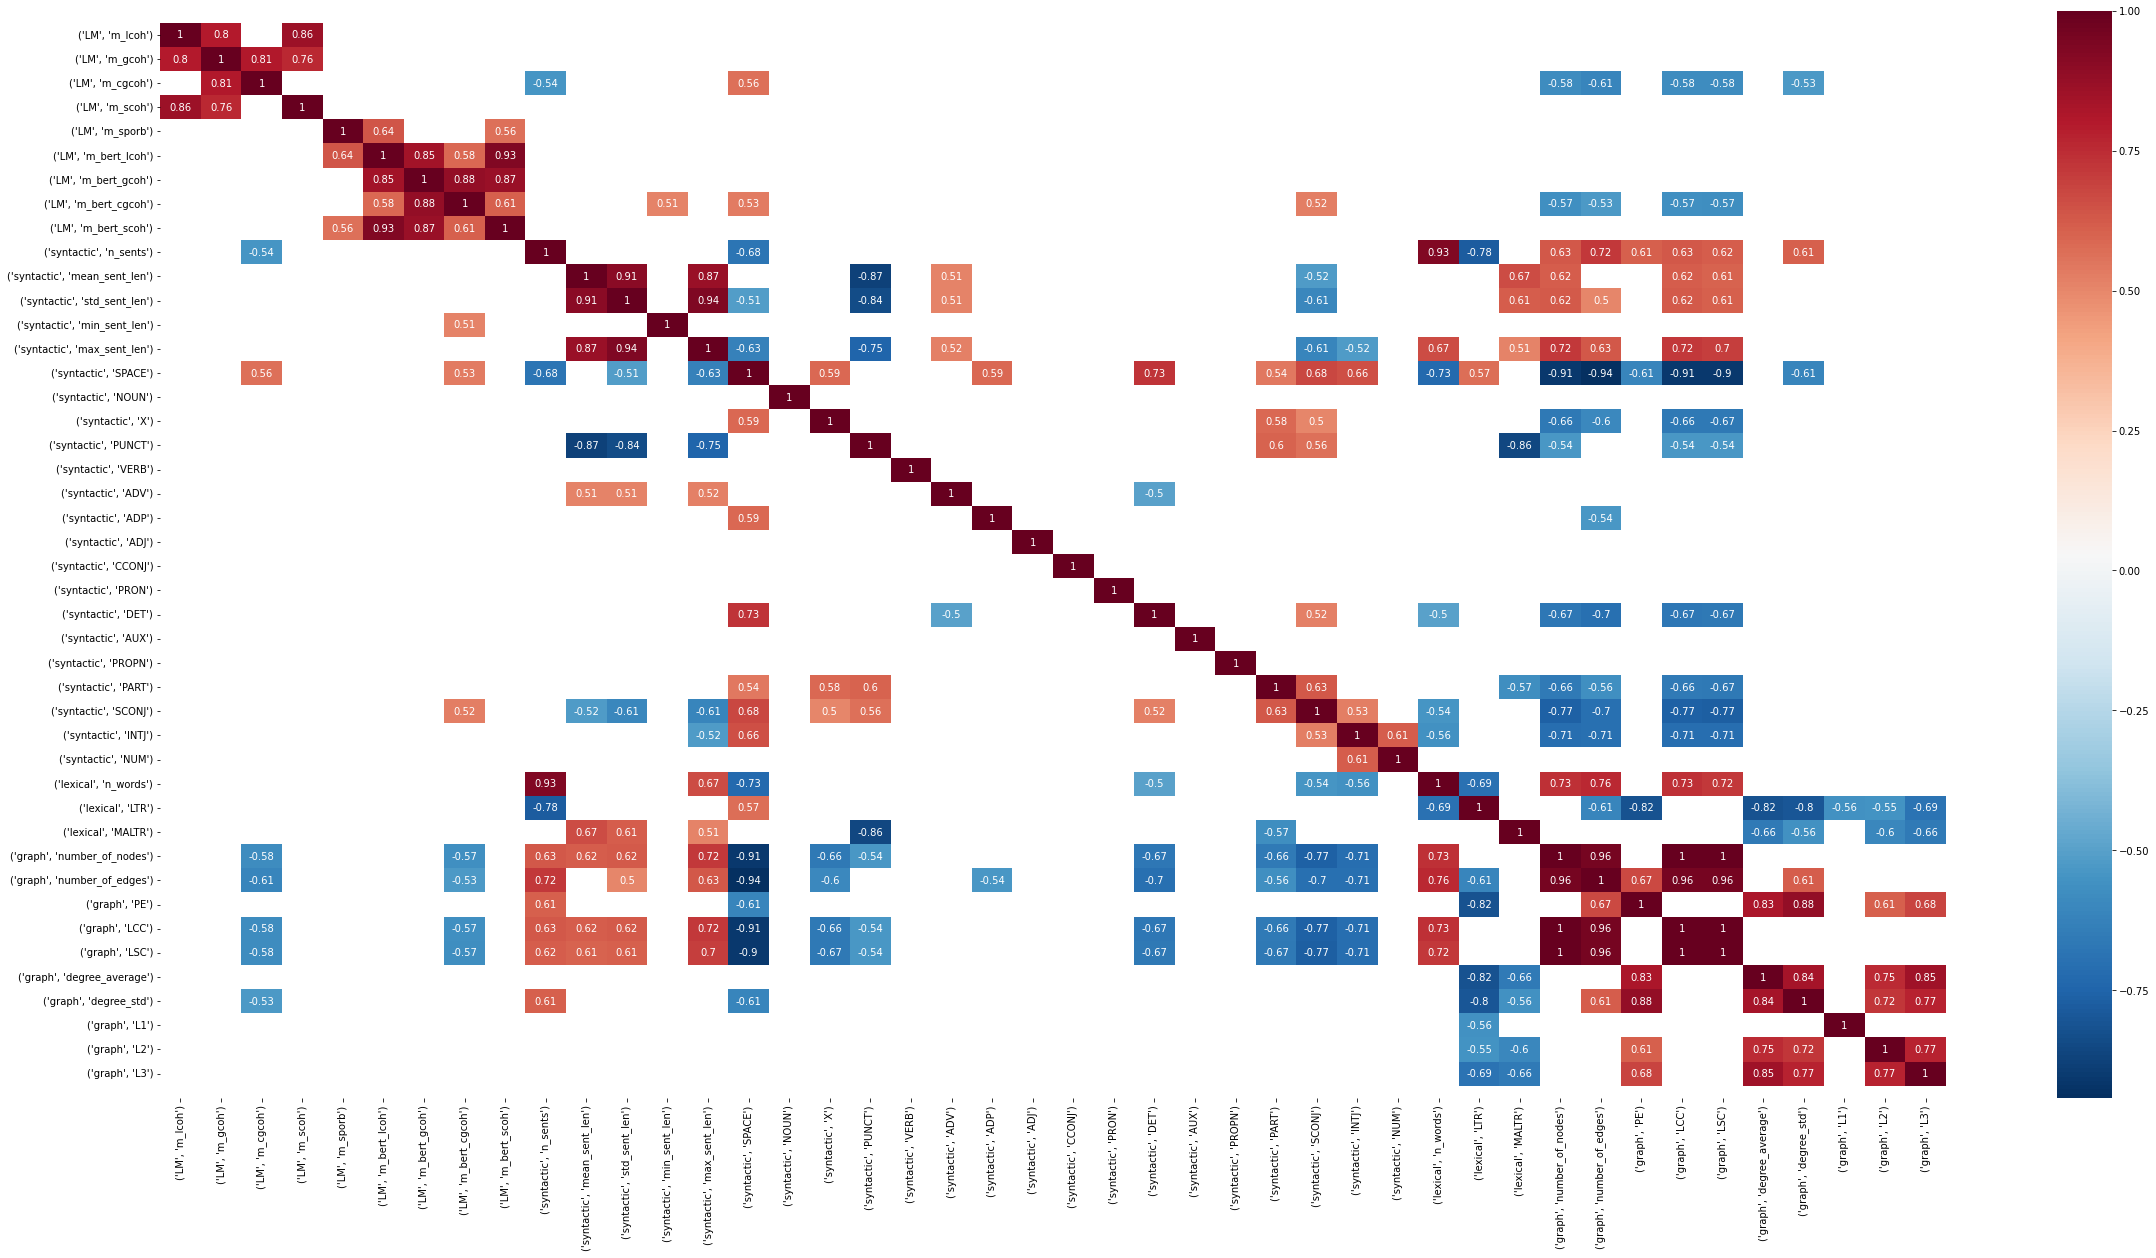

In [163]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_av])